
### 1. Shape Functions for 2D Q1 (Bilinear) Elements

For a rectangular element with local coordinates $(\xi, \eta) \in [0,1] \times [0,1]$, the four bilinear shape functions are:

- $\phi_1(\xi, \eta) = (1 - \xi)(1 - \eta)$ (bottom-left node)
- $\phi_2(\xi, \eta) = \xi (1 - \eta)$ (bottom-right node)
- $\phi_3(\xi, \eta) = \xi \eta$ (top-right node)
- $\phi_4(\xi, \eta) = (1 - \xi)\eta$ (top-left node)

These satisfy:
- $\phi_i = 1$ at node $i$, $\phi_i = 0$ at other nodes.

### 2. Local Mass Matrix

The local mass matrix for an element $e$ is:
$$
Me_{ij} = \iint_{\text{element}} \phi_i(x, y) \phi_j(x, y) \, dx\,dy
$$

For a rectangle of size $dx \times dy$, using the above shape functions and integrating over the reference element, the result is:
$$
Me = \frac{dx\,dy}{36}
\begin{bmatrix}
4 & 2 & 1 & 2 \\
2 & 4 & 2 & 1 \\
1 & 2 & 4 & 2 \\
2 & 1 & 2 & 4
\end{bmatrix}
$$

### 3. Local Stiffness Matrix

The local stiffness matrix is:
$$
Ke_{ij} = \iint_{\text{element}} \alpha \left( \nabla \phi_i \cdot \nabla \phi_j \right) dx\,dy
$$

For a rectangular element, the gradients are:
- $\frac{\partial \phi_1}{\partial x} = -\frac{1}{dx}(1-\eta)$, $\frac{\partial \phi_1}{\partial y} = -\frac{1}{dy}(1-\xi)$
- $\frac{\partial \phi_2}{\partial x} = \frac{1}{dx}(1-\eta)$, $\frac{\partial \phi_2}{\partial y} = -\frac{1}{dy}\xi$
- $\frac{\partial \phi_3}{\partial x} = \frac{1}{dx}\eta$, $\frac{\partial \phi_3}{\partial y} = \frac{1}{dy}\xi$
- $\frac{\partial \phi_4}{\partial x} = -\frac{1}{dx}\eta$, $\frac{\partial \phi_4}{\partial y} = \frac{1}{dy}(1-\xi)$

After integrating, the local stiffness matrix is:
$$
Ke = Ke_x + Ke_y
$$
where
$$
Ke_x = \frac{\alpha\,dy}{6\,dx}
\begin{bmatrix}
2 & -2 & 1 & -1 \\
-2 & 2 & -1 & 1 \\
1 & -1 & 2 & -2 \\
-1 & 1 & -2 & 2
\end{bmatrix}
$$

$$
Ke_y = \frac{\alpha\,dx}{6\,dy}
\begin{bmatrix}
2 & 1 & -2 & -1 \\
1 & 2 & -1 & -2 \\
-2 & -1 & 2 & 1 \\
-1 & -2 & 1 & 2
\end{bmatrix}
$$

### 4. Summary

- **Shape functions:** Bilinear, as above.
- **Mass matrix:** $\displaystyle Me = \frac{dx\,dy}{36} \begin{bmatrix} 4 & 2 & 1 & 2 \\ 2 & 4 & 2 & 1 \\ 1 & 2 & 4 & 2 \\ 2 & 1 & 2 & 4 \end{bmatrix}$
- **Stiffness matrix:** $Ke = Ke_x + Ke_y$ as above, with $Ke_x$ and $Ke_y$ given by the explicit formulas.

/home/indu/MELO/1D_FEM_JAX/JAX_FEM/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
/home/indu/MELO/1D_FEM_JAX/JAX_FEM/lib/python3.12/site-packages/jax/_src/numpy/array_creation.py:531: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  delta: Array = lax.convert_element_type(stop - start, computation_dtype) / asarray(div, dtype=computation_dtype)
/home/indu

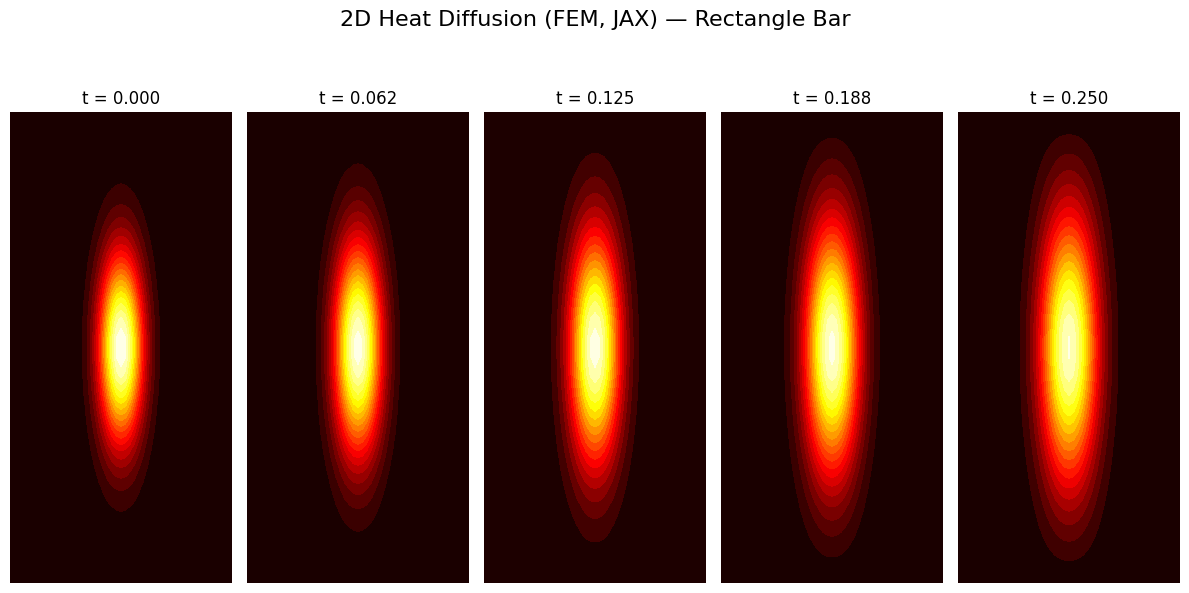

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# Problem parameters
# ------------------------------------------------------------------
Lx, Ly = 1.0, 0.5          # Domain size in x and y
Nx, Ny = 51, 26            # Number of grid points
dx, dy = Lx/(Nx-1), Ly/(Ny-1)
alpha = 0.01               # Thermal diffusivity
dt = 0.0005                # Time step
Nt = 500                   # Number of time steps

# Grid for plotting
x = jnp.linspace(0, Lx, Nx)
y = jnp.linspace(0, Ly, Ny)
X, Y = jnp.meshgrid(x, y, indexing='ij')

# Initial condition: Gaussian hump in the center
u0_2d = jnp.exp(-100 * ((X - Lx/2)**2 + (Y - Ly/2)**2))

# ------------------------------------------------------------------
# Local element (4-node bilinear) mass and stiffness matrices
# ------------------------------------------------------------------
def element_matrices_2d(dx, dy, alpha):
    # Consistent mass matrix
    Me = (dx * dy / 36.0) * jnp.array([
        [4, 2, 1, 2],
        [2, 4, 2, 1],
        [1, 2, 4, 2],
        [2, 1, 2, 4]
    ])
    # Stiffness contributions in x and y
    Ke_x = (alpha * dy / (6 * dx)) * jnp.array([
        [ 2, -2,  1, -1],
        [-2,  2, -1,  1],
        [ 1, -1,  2, -2],
        [-1,  1, -2,  2]
    ])
    Ke_y = (alpha * dx / (6 * dy)) * jnp.array([
        [ 2,  1, -2, -1],
        [ 1,  2, -1, -2],
        [-2, -1,  2,  1],
        [-1, -2,  1,  2]
    ])
    return Me, (Ke_x + Ke_y)

Me2d, Ke2d = element_matrices_2d(dx, dy, alpha)

# ------------------------------------------------------------------
# Assemble global M and K (dense—suitable for small Nx,Ny)
# ------------------------------------------------------------------
def assemble_2d(Nx, Ny, Me, Ke):
    N = Nx * Ny
    M = jnp.zeros((N, N))
    K = jnp.zeros((N, N))
    for i in range(Nx - 1):
        for j in range(Ny - 1):
            # local node indices
            n0 = i*Ny + j
            n1 = (i+1)*Ny + j
            n2 = (i+1)*Ny + (j+1)
            n3 = i*Ny + (j+1)
            idx = jnp.array([n0, n1, n2, n3])
            M = M.at[jnp.ix_(idx, idx)].add(Me)
            K = K.at[jnp.ix_(idx, idx)].add(Ke)
    return M, K

M2d, K2d = assemble_2d(Nx, Ny, Me2d, Ke2d)

# ------------------------------------------------------------------
# Enforce homogeneous Dirichlet BCs (u = 0 on all boundaries)
# ------------------------------------------------------------------
def apply_bc_matrix_2d(M, K, Nx, Ny):
    N = Nx * Ny
    boundary_nodes = []
    for i in range(Nx):
        for j in range(Ny):
            if i == 0 or i == Nx-1 or j == 0 or j == Ny-1:
                boundary_nodes.append(i*Ny + j)
    for b in boundary_nodes:
        M = M.at[b, :].set(0)
        M = M.at[:, b].set(0)
        M = M.at[b, b].set(1)
        K = K.at[b, :].set(0)
        K = K.at[:, b].set(0)
    return M, K

M2d_bc, K2d_bc = apply_bc_matrix_2d(M2d, K2d, Nx, Ny)

# Precompute the time‐stepping matrix
A2d = M2d_bc + dt * K2d_bc
A2d_inv = jnp.linalg.inv(A2d)

# ------------------------------------------------------------------
# JIT‐compiled single time‐step (Nx, Ny are closed over as static)
# ------------------------------------------------------------------
@jax.jit
def step_2d(u, M_bc, A_inv):
    # Build RHS
    b = M_bc @ u
    # Solve for next u
    u_new = A_inv @ b

    # Reshape into 2D field and re‐apply Dirichlet BCs explicitly
    u_mat = u_new.reshape((Nx, Ny))
    u_mat = u_mat.at[0, :].set(0.0)
    u_mat = u_mat.at[-1, :].set(0.0)
    u_mat = u_mat.at[:, 0].set(0.0)
    u_mat = u_mat.at[:, -1].set(0.0)

    return u_mat.ravel()

# ------------------------------------------------------------------
# Run full simulation
# ------------------------------------------------------------------
def run_sim_2d(u0, Nt, M_bc, A_inv):
    u = u0.ravel()
    snapshots = [u.reshape((Nx, Ny))]
    for _ in range(Nt):
        u = step_2d(u, M_bc, A_inv)
        snapshots.append(u.reshape((Nx, Ny)))
    return jnp.stack(snapshots)

us_2d = run_sim_2d(u0_2d, Nt, M2d_bc, A2d_inv)

# ------------------------------------------------------------------
# Plot results at five equally‐spaced times
# ------------------------------------------------------------------
plt.figure(figsize=(12, 6))
for idx, t_idx in enumerate(jnp.linspace(0, Nt, 5, dtype=int)):
    plt.subplot(1, 5, idx+1)
    plt.contourf(X, Y, us_2d[t_idx], levels=20, cmap='hot')
    plt.title(f"t = {t_idx*dt:.3f}")
    plt.axis('off')

plt.suptitle("2D Heat Diffusion (FEM, JAX) — Rectangle Bar", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()
